# MATH3330 Term Project: Community Detection

## 1. Project Overview

The goal of this term project is to explore community detection algorithms for non-trivial graphs.
In contrast to previous worksheets, the term project is more self-directed.
You are encouraged to try different graphs, and to find limitations in the community detection algorithms.

The structure of the term project is as follows.
1. **Graph Generation:**
   In this worksheet, you have been provided with two graph models.
   These models are designed to ensure that each graph has two or more well-defined communities.
   You will parameterize each model to generate 5 different graphs from each model.
2. **Community Detection:**
   There are many algorithms for community detection, each with their own advantages and disadvantages.
   This project considers label propogation, modularity maximization, and the Girvan-Newman algorithm.
   You will apply each algorithm to each graph, and observe the communities they detect.
3. **Community Evaluation:**
   Modularity and the Rand Index are two measures of how "good" a set of communities are at partitioning a graph.
   The Rand Index is simpler to compute, but requires that you know the "true" set of communities.
   You will evaluate each community detection algorithm by computing the modularity and Rand Index for each graph.
4. **Conclusions:**
   From the above, you will compare the strengths and weaknesses of each community detection algorithm.

As in previous worksheets, we will start by importing the tools we need.

In [1]:
import networkx as nx
import random
import numpy as np                      
import matplotlib.pyplot as plt
# itertools will help us work with the Girvan-Newman algorithm.
# Examples will be provided as we demonstrate how to use the Girvan-Newman algorithm in NetworkX.
import itertools

## 2. Graph Generation

### 2.1 The Stochastic Block Model

The **Stochastic Block Model (SBM)** is a model that can generate graphs with communities.
In the SBM, vertices are partitioned into blocks (*i.e. sets of vertices with similar connectivity to other vertices -- this is **not** the graph-theoretical definition of block as seen in class*).
For a vertex in block $i$, and a vertex in block $j$, an edge exists from $i$ to $j$ with probability $p(i,j)$.
If probabilities are high for vertices in the same block, and low for vertices in different blocks, then each block will correspond to a community.
You can read more about the SBM on pages 172-173 of the network science book as posted on Brightspace.

An example of how to generate a SBM with communities is given below.

Number of communities: 3
Number of nodes in the first block: 55
Number of nodes in the third block: 33

The size of the probability matrix is: 3 x 3
The probability of an edge within the first community is high: 0.9
The probability of an edge from the first to third community is low: 0.05
The probability of an edge from the third to first community is the same: 0.05


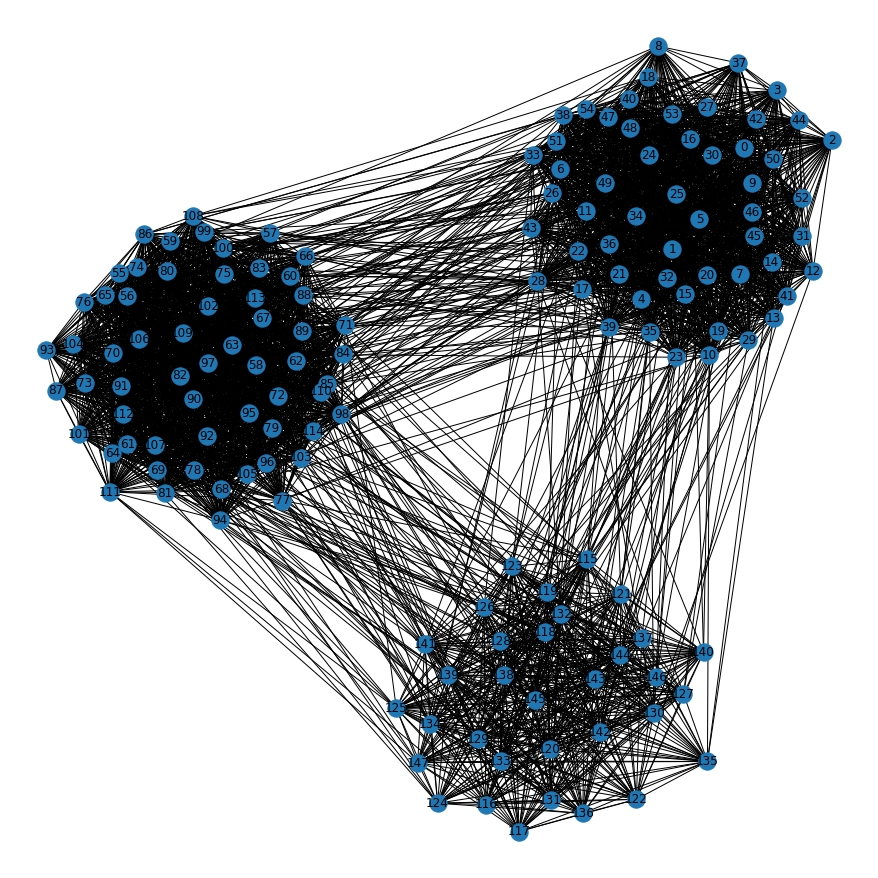

In [3]:
# The first parameter to the SBM is the number of vertices in each block.
# This is represented by a list of integers giving the order of each block.
community_sizes = [ 55, 60, 33 ]

# This list describes a stochastic block model with 3 blocks.
print("Number of communities:", len(community_sizes))

# The first block has 55 nodes, and the third block has 33 nodes (recall that list indices start from 0).
print("Number of nodes in the first block:", community_sizes[0])
print("Number of nodes in the third block:", community_sizes[2])

# Probabilities are represented by a probability matrix.
probabilities = [
    [ 0.9, 0.05, 0.05 ],
    [ 0.05, 0.9, 0.05 ],
    [ 0.05, 0.05, 0.9 ],
]

# The matrix should be nxn, where n is the number of blocks.
print()
print("The size of the probability matrix is:", len(probabilities), "x", len(probabilities[0]))
# Note that, when you increase the number of blocks, you need to make a bigger probability matrix.

# The element at (i,j) is the probability that an edge appears from block i to block j.
print("The probability of an edge within the first community is high:", probabilities[0][0])
print("The probability of an edge from the first to third community is low:", probabilities[0][2])

# The matrix should be symmetric, since edges are undirected.
print("The probability of an edge from the third to first community is the same:", probabilities[2][0])

# NetworkX has a method to generate SBMs.
# Normally, we would want this model to be random.
# However, in this assignment we would like our experiments to be reproducible.
# We will tell NetworkX to generate the same SBM (given the same parameters) by setting the "random seed".
seed = 99 # This can be any number, though some numbers might generate uninteresting models.
stochastic_block_model = nx.stochastic_block_model(community_sizes, probabilities, seed=seed)
# Be sure to set the seed each time you use nx.stochastic_block_model.

# Now let's look at the graph.
plt.figure(figsize=[12,12])
nx.draw(stochastic_block_model, with_labels=True)
plt.show()

<span style="color:blue">NOTE:</span>
It may take a while to visualize large graphs. You can see whether a cell is still running: in the left margin it will say [\*] instead of [(some number)]. Note that the visualization of the graph accentuates the communities.

### 2.2 Designing Our Own Models

In this section we will create our own graph models.
Our models will be simple, and adhere to the following outline:

1. Generate a large graph with low density (*e.g., an Erdős–Rényi graph with low edge probability*).
2. Use the nodes of the large graph to generate smal graphs with high density (*e.g., a k-complete graph*).
3. Compose the small graphs with the large graph to obtain a new graph with dense communities.

We will refer to the large graph as the *background graph* and the small graphs as the *community graphs*.
An example using a sparse *Erdős–Rényi* background graph, and two dense *Erdős–Rényi* community graphs is given below.

<span style="color:blue">NOTE:</span>
An important difference between the graphs generated in 2.1 according to the SBM model, and the graphs generated here is the following: in the SBM graphs, **every** vertex is part of a community; the communities form a **partition** of the vertex set. In contrast, here in Section 2.2 we generate graphs there are many vertices that are not part of any of the communities; they are only part of the background graph. 

Background is connected: True
First three nodes: [320, 321, 322]


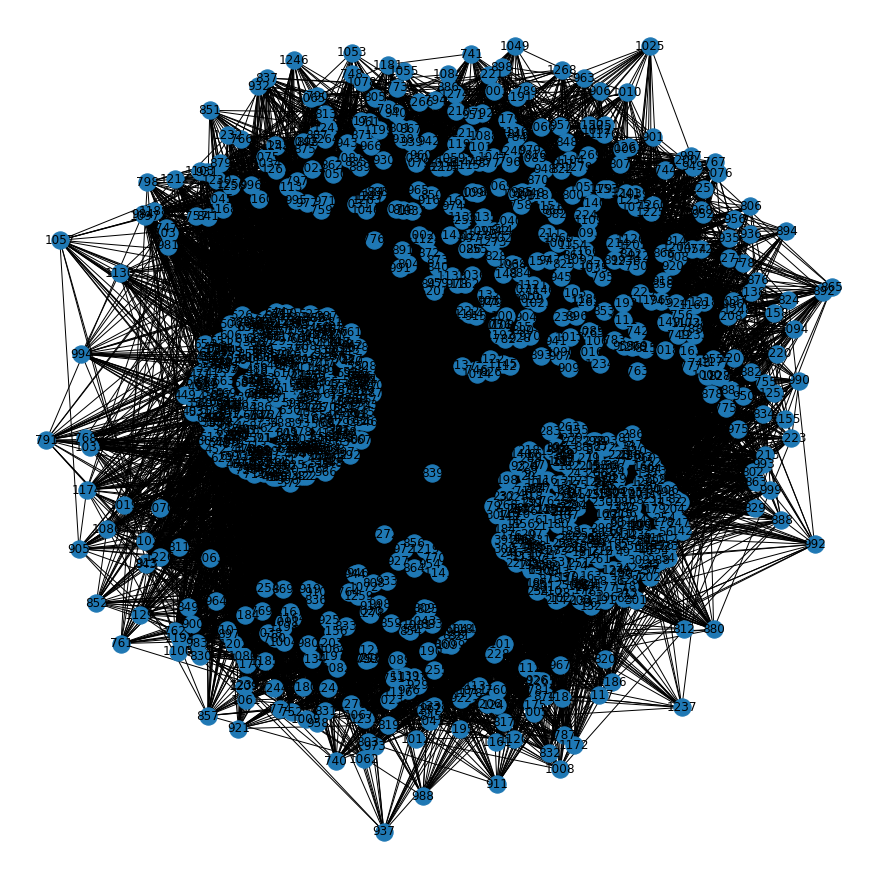

In [4]:
# First we generate the background graph.
sid = 108 # See 2.1 for details.
background_graph = nx.erdos_renyi_graph(1280, 0.03, seed=sid)
# You can change parameters, but also try a different graph model:#
# background_graph = nx.gnm(1100, 8200, seed=sid) # 8200 edges randomly distributed among 110 vertices
# background_graph = barabasi_albert_model(1200,10, seed=sid) # Graph that has power law distribution

# It is useful to check if the background graph is connected.
# If you want to experiment with a connected graph and the graph is not connected, you can try changing the seed.
print("Background is connected:", nx.is_connected(background_graph))

# Third we generate the community graphs
# The first community is a dense random graph using nodes 0 to 319.
community_graph_1 = nx.erdos_renyi_graph(320, 0.9, seed=sid)
# The second community is a dense random graph using nodes 320 to 739.
# First we generate the graph on vertices 0 to 439.
temporary_graph = nx.erdos_renyi_graph(420, 0.9, seed=sid)
# The next two lines of code relabel the nodes to 320 to 739.
mapping = dict(zip(temporary_graph, range(320,740)))
community_graph_2 = nx.relabel_nodes(temporary_graph, mapping)
# To test that this went well, the next line prints the first three nodes.
print("First three nodes:", list(community_graph_2.nodes())[:3])

# Then we compose the background graph with the community graphs.
composite_graph = nx.compose(background_graph, community_graph_1)
composite_graph = nx.compose(composite_graph, community_graph_2)

# Now let's look at the graph.
plt.figure(figsize=[12,12])
nx.draw(composite_graph, with_labels=True)
plt.show()

Note how the figures of the first and second graph both show the communities, but in different ways!

In [5]:
# Note that if you are working with a Barabási-Albert, then the degree sequence will be biased.
# In these cases, you might want to permute the vertices in the Barabási-Albert graph before composition.
# This step is optional, but may lead to interesting results.
# An example is given below.

# Create the graph.
sid = 101 # See 2.1 for details.
barabasi_albert_example = nx.barabasi_albert_graph(64, 2, seed=sid)

# Shuffle the vertices.
sid = 101 # See 2.1 for details.
nodes = list(barabasi_albert_example.nodes())
random.Random(sid).shuffle(nodes)

# Relabel the edges, as in the above example.
mapping = dict(zip(community_graph_1, nodes))
barabasi_albert_example = nx.relabel_nodes(barabasi_albert_example, mapping)

# To test that this went well, the next line prints the first three nodes.
print("Three vertex labels, now in a random order:", list(barabasi_albert_example.nodes())[:3])

Three vertex labels, now in a random order: [62, 17, 49]


## 3. Community Detection

### 3.1 Label Propogation

Label propogation is a fast and simple algorithm to detect communities in a graph.
In label propogation, each node is assigned a unique identifier called a *label*.
The algorithm works by sweeping over the nodes in the graph, and updating the label of each node to the majority label it its neighbourhood.
The algorithm terminates once all labels have stabilized.
To read more about label propogation, see pages 171-172 of the network science book.

A simple example of label propogation is given below.

In [6]:
# Label propagation does not have any parameters.
# As an example we apply label propagation to our SBM graph called stochastic_block_model
# Note that label_propagation_communities returns a special value that requires a for-loop.
# However, we can extract the subgraphs and store them in a list.
SBM_communities = []
for C in nx.community.label_propagation_communities(stochastic_block_model):
    # The community C is a list of nodes; here we generated the subgraphs induced by these nodes
    SBM_communities.append(stochastic_block_model.subgraph(C)) # community C is added to the list SBM_communities

# We know that our graph has three communities: let's verify the results.
print("Number of communities:", len(SBM_communities))
print("Community sizes:")
for community in SBM_communities:
    print(community.order())

Number of communities: 3
Community sizes:
60
55
33


As we see, the sizes are correct, but this does not tell us everything. We will see later how to test the quality of the communities found by these algorithms.

### 3.2 Modularity Optimization

Modularity is a measure of how closely a graph partition resembles a set of communities.
A natural approach to community detection is to search for partitions that optimize modularity.
However, modularity optimization is very slow in general.
In practice, we use *greedy algorithms* that take shortcuts in the hopes of finding a nearly optimal partitioning.
For a more in-depth discussion of modularity optimization, see pages 165-171 of the notes on community detection.
To read about the specific algorithm we are about to use, see https://arxiv.org/abs/cond-mat/0408187.

A simple example of modularity opitmization is given below.

In [7]:
# Let's apply this algorithm to the composite graph we built in Section 2.2

# Modularity Optimization can be applied without any parameters.
# As before, we can extract the subgraphs with a for-loop and store them in a list.
CM_communities = []
for C in nx.community.greedy_modularity_communities(composite_graph):
    # The community is a list of nodes.
    CM_communities.append(composite_graph.subgraph(C))
    
print("Number of communities:", len(CM_communities))
print("Community sizes:")
for community in CM_communities:
    print(community.order())

Number of communities: 3
Community sizes:
493
424
363


Our composite graph had two communities of order 320 and 740, set in a background graph of order 1280. So there are 220 nodes that are not part of any community. However, all community detection algorithm shown here give a *partition* of all nodes, so the 220 nodes will either be added to the two communities, or put in separate communities. 

Note that this code takes much longer to run than the code in the previous cell, even though the code 
looks very similar. Can you guess why?

<span style="color:purple">Optionally share your guesses here:</span> In label propogation, there is no indicator that can measure the quality of the current community division. Modularity can measure the quality of community division. A relatively good result is that the nodes within the community are more densely connected, and the connections between communities are more sparse.  

### 3.3 The Girvan-Newman Algorithm

The Girvan-Newman algorithm detects communities by removing edges in a graph.
On each iteration, the Girvan-Newman algorithm removes the edge with the highest *edge betweenness*.
Recall that edge betweenness measures the proportion of shortest paths through a given edge.
We expect communities to be dense, and therefore, we also expect bridges between communities to have high edge betweenness.
The Girvan-Newman algorithm is more efficient than optimal modularity partitioning, but still slower than the other techniques due to the cost of computing edge betweenness.
For a more in-depth discussion of modularity optimization, see pages 163-165 of the network science book.

Note that one drawback of the Girvan-Newman algorithm is that it does not decide the optimal number of edges to remove.
Instead, the Girvan-Newman algorith returns a list of all possible partitions obtained by removing edges.
Normally, we would visualize this list as a dendrogram (e.g., https://en.wikipedia.org/wiki/Dendrogram).
However, generating a dendogram is beyond the scope of this project.
Instead, we will use our insight about the underlying models to select a "reasonable" partitioning.
A simple example of the Girvan-Newman algorithm is given below.

In [8]:
# This example is taken from the NetworkX documentation.
# It shows the Girvan_Newman algorithm applied to a  path graph of 8 vertices.
# The Girvan-Newman algorithm produces a sequence of ever finer partitions.
# We can decide to only extract the partitions with at most k parts.

G = nx.path_graph(8)

comp = nx.community.girvan_newman(G)
k = 3
# The command below runs the algorithm until k communities are reached.
limited = itertools.takewhile(lambda c: len(c) <= k, comp)

# Pick out the partition that has t parts.
t = 3 # t must be less than or equal to k.
for partition in limited:
    if len(partition) == t:   #picks out the partition that has t parts
        chosen_partition=partition

# chosen_partition is the partition that has t parts.

# Turn the communities into subgraphs.
G_communities = []
for C in chosen_partition:
    G_communities.append(G.subgraph(C))
        
print("Number of communities:", len(G_communities)) # this should be equal to t
print("Community sizes:")
for community in G_communities:
    print(community.order())

Number of communities: 3
Community sizes:
2
2
4


We now apply the Girvan-Newman algorithm to the Stochastic Block Model graph. The algorithm is slow; this may take a while. 

In [9]:
# We now apply the Girvan-Newman algorithm to the stochastic block model graph from Section 2.2.
comp = nx.community.girvan_newman(stochastic_block_model)

k = 3
t = 3 # Must be that 2 <= t <= k+1, this is the number of communities we extract.
for partition in itertools.islice(comp, k):
    # Picks out the partition that has t parts.
    if len(partition) == t:
        chosen_partition = partition
    # chosen_partition is the partition that has t parts

# Turn the communities into subgraphs.
SBM_GN_communities = []
for C in chosen_partition:
    SBM_GN_communities.append(stochastic_block_model.subgraph(C))
        
print("Number of communities:", len(SBM_GN_communities)) # This should be equal to t.
print("Community sizes:")
for community in SBM_GN_communities:
    print(community.order())

Number of communities: 3
Community sizes:
55
60
33


## 4. Community Evaluation

Now you will evaluate the communties found by using label propogation, modularity optimization, and the Girvan-Newman algorithm.

### 4.1 Modularity

First, you will evaluate the communities using modularity.
Modularity is a useful measure as it does not require knowledge of the "true" communities.
Instead, it compares the edges within each community to the edges induced by the cut of the community.
If the edges within the community are much higher than those within the cut, then the community is self-contained, and the modularity is high.

An example of how to compute modularity is given below. Recall that G is the path graph $P_8$, which has no
obvious communities. 

In [10]:
nx.community.modularity(G,G_communities)

0.33673469387755106

Now let's test the modularity of the two community partitions of the stochastic block model graph.

In [11]:
nx.community.modularity(stochastic_block_model,SBM_communities)

0.5248775509970888

### 4.2 The Rand Index

Second, you will evaluate the communities using the Rand Index.
The Rand Index is a way to compare a *ground truth* partitioning (*i.e., the communities we created*) to an empirical partitioning (*i.e., the communities found by a community detection algorithm*).
The ground truth partitioning tells us which pairs of nodes appear in the same community.
The Rand Index measures the percentage of pairs of nodes that agree with the ground truth.
More precisely, the Rand Index is $\frac{a + b}{n ( n - 1 ) / 2}$ where $a$ is the number of pairs of nodes that correctly appear in the same community, $b$ is the number of pairs of nodes that correctly appear in different communities, and $n$ is the number of nodes in $G$ (for more detail, see https://en.wikipedia.org/wiki/Rand_index).

An example of how to compute the Rand Index is given below. First we construct a matrix for each community 
partition, including the ground truth. The matrix has entry $(i,j)$ equal 1 if $i$ and $j$ are in the same community,
and equal to zero if they are in different communities. Then to compute $a+b$ as given below we just have to 
count the entries $(i,j)$ where the matrix representing the ground truth and the matrix representing the community partition given by the algorithm either are both 1 (contributing to $a$), or both 0 (contributing to $b$).  

In [12]:
# Construct the ground truth communities, using the community sizes.
t = 0
ground_truth = []
for n in community_sizes:
    ground_truth.append(list(range(t, t+n)))
    t = t+n
# The code above uses the fact that the communities follow the natural ordering of the nodes (i.e., 0, 1, 2, ...).
# Therefore, the communities consist of nodes {0,...,n1}{n1+1,...,n2},...

n = stochastic_block_model.order()

# Compute the matrix for the ground truth.
ground_truth_matrix = np.zeros([n, n], dtype=int)
for community in ground_truth:
    for i in community:
        for j in community:
            ground_truth_matrix[i][j] = 1

# The empirical matrix for the communities obtained with label propagation (section 3.1)
empirical_matrix = np.zeros([n, n], dtype=int)
for community in SBM_communities:
    for i in community:
        for j in community:
            empirical_matrix[i][j] = 1

# Computes the Rand Index.
a = 0
b = 0
for i in range(0, n):
    # We start at (i + 1), rather than 0, to avoid double counting.
    for j in range(i + 1, n):
        if ground_truth_matrix[i, j] == 1 and empirical_matrix[i][j] == 1:
            a += 1
        if ground_truth_matrix[i, j] == 0 and empirical_matrix[i][j] == 0:
            b += 1
rand_index = (a + b) / (n * (n - 1) / 2.0)
print("The Rand Index:", rand_index)

The Rand Index: 1.0


The Rand Index has the maximum possible value, so as we suspected from seeing the sizes, label propagation gave
a perfect partition. 

### 5. Do Your Own Experiment

Now it is your turn.
Using the above code as a template, generate a number of graphs, apply the community detection algorithms, and evaluate them. Some of the graphs should have order at least 1000, others can be smaller (Girvan-Newman and visualizataion take too long on large graphs). For the small graphs, you can draw them and visually inspect the result. For the larger graphs, you must depend on the evaluation methods. 

Explain your choices at every step below. This part should read like a report, where you explain your choices for the experiment, and analyze the outcomes.

### 5.1 Stochastic Block Model
Start with generating at least five graphs according to the stochastic block model, as in Section 2.1. You will want to give each graph a different name so that we can refer back to them throughout the project (*e.g.,* `SBM_1` *through to* `SCM_5`).
In each graph, be sure to change parameters such as:

- The number of communities.
- The number of vertices within a communities.
- The probabilities in the probability matrix.
- The seed.

For each graph, think about how changing the parameters will impact communities and community detection.
You should create **at least** one graph where the probabilities do not differ by much; try to find out when the community detection algorithms break down. 

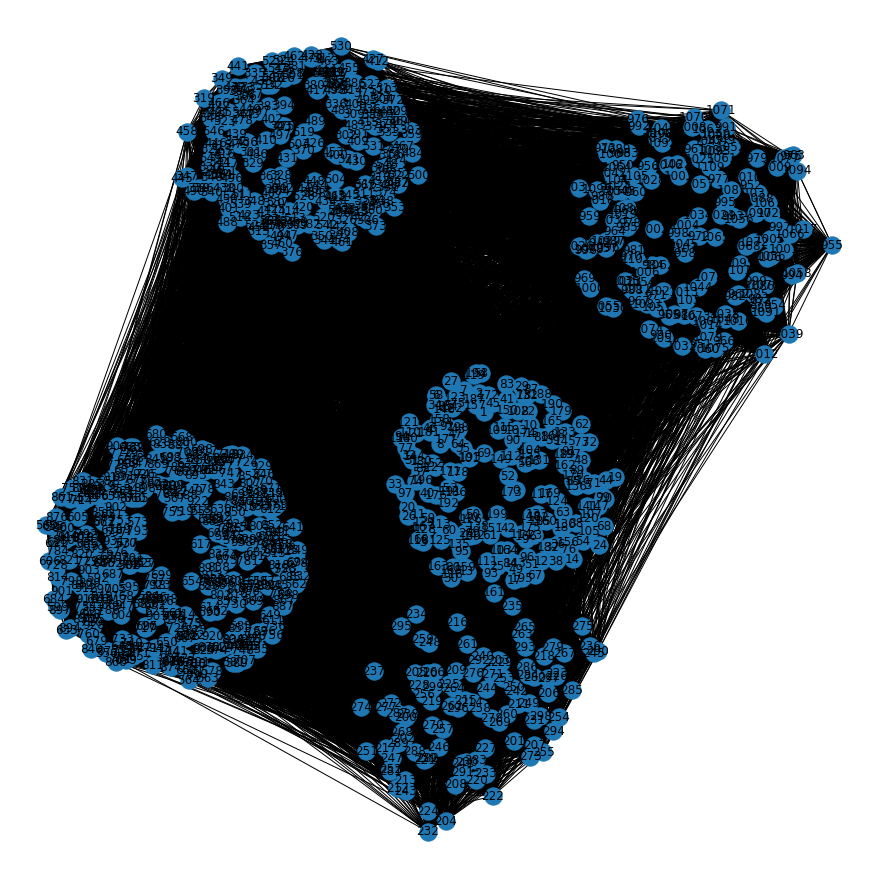

In [13]:
# ...your code here...
community_sizes_1 = [200, 100, 250, 400, 160]
probabilities_1 = [
    [0.8, 0.05, 0.03, 0.04, 0.02],
    [0.05, 0.5, 0.01, 0.05, 0.03],
    [0.03, 0.01, 0.9, 0.02, 0.03],
    [0.04, 0.05, 0.02, 0.6, 0.01],
    [0.02, 0.03, 0.03, 0.01, 0.7]
]

seed_1 = 88
SBM_1 = nx.stochastic_block_model(community_sizes_1, probabilities_1, seed=seed_1)
plt.figure(figsize=[12,12])
nx.draw(SBM_1, with_labels=True)
plt.show()

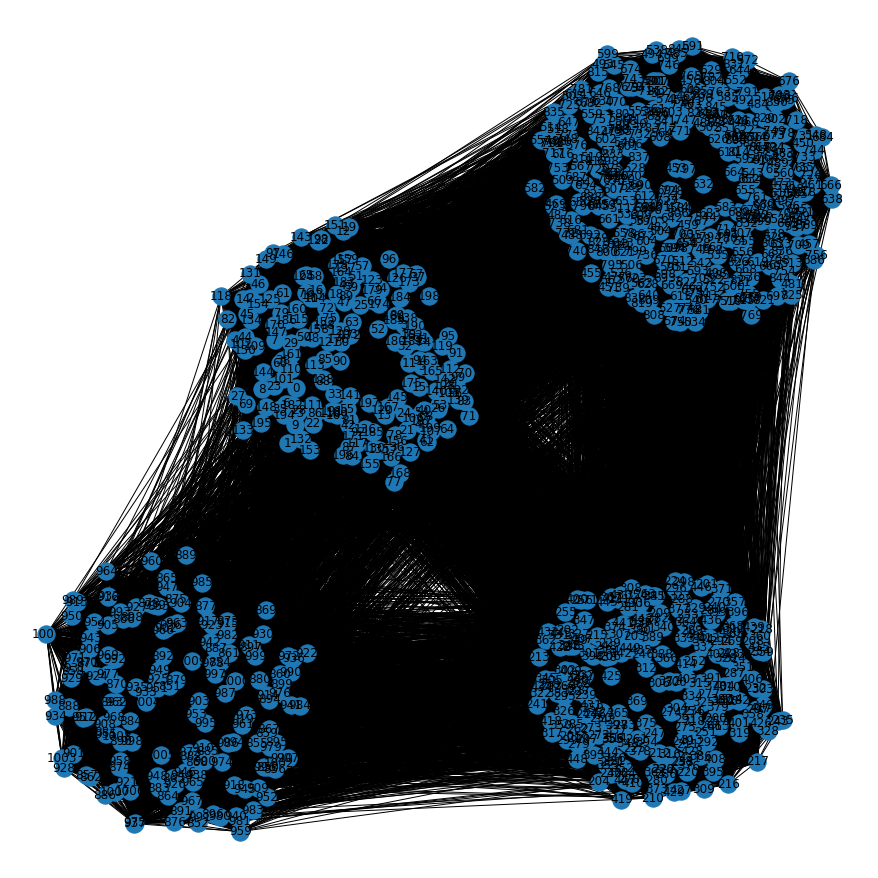

In [14]:
# ...your code here...
community_sizes_2 = [200, 250, 400, 160]
probabilities_2 = [
    [0.8, 0.03, 0.04, 0.02],
    [0.03, 0.9, 0.02, 0.03],
    [0.04, 0.02, 0.6, 0.01],
    [0.02, 0.03, 0.01, 0.7]
]
seed_2 = 88
SBM_2 = nx.stochastic_block_model(community_sizes_2, probabilities_2, seed=seed_2)
plt.figure(figsize=[12,12])
nx.draw(SBM_2, with_labels=True)
plt.show()

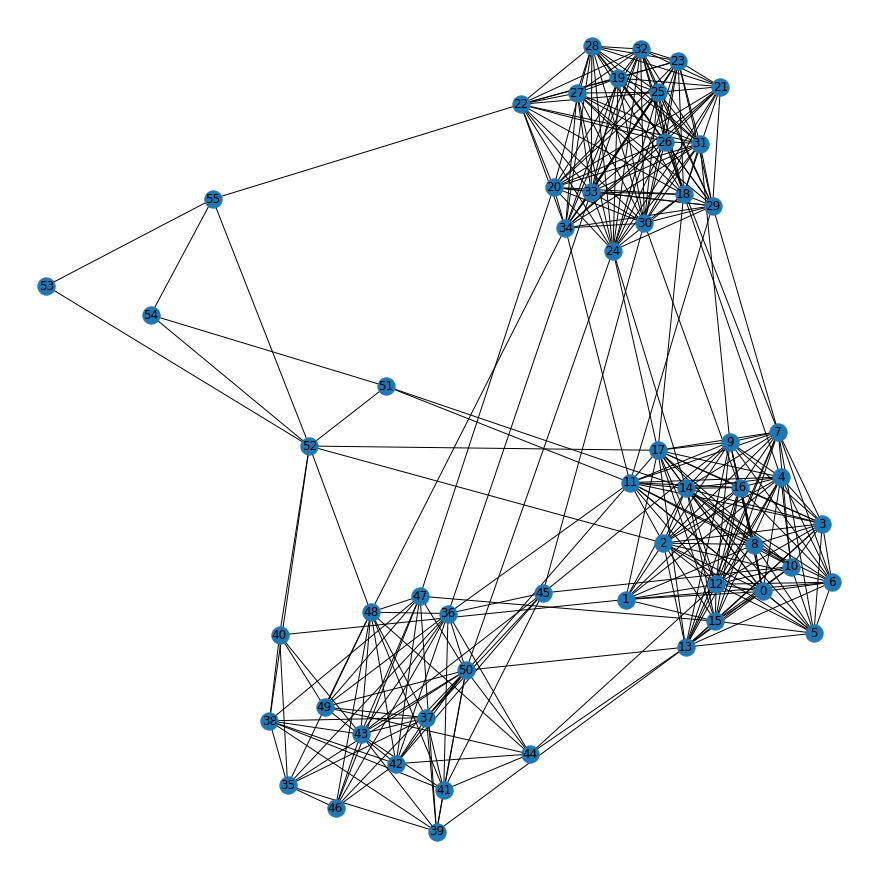

In [15]:
# ...your code here...
community_sizes_3 = [18, 17, 16, 5]
probabilities_3 = [
    [0.8, 0.03, 0.04, 0.02],
    [0.03, 0.9, 0.02, 0.03],
    [0.04, 0.02, 0.6, 0.01],
    [0.02, 0.03, 0.01, 0.7]    
]
seed_3 = 88
SBM_3 = nx.stochastic_block_model(community_sizes_3, probabilities_3, seed=seed_3)
plt.figure(figsize=[12,12])
nx.draw(SBM_3, with_labels=True)
plt.show()

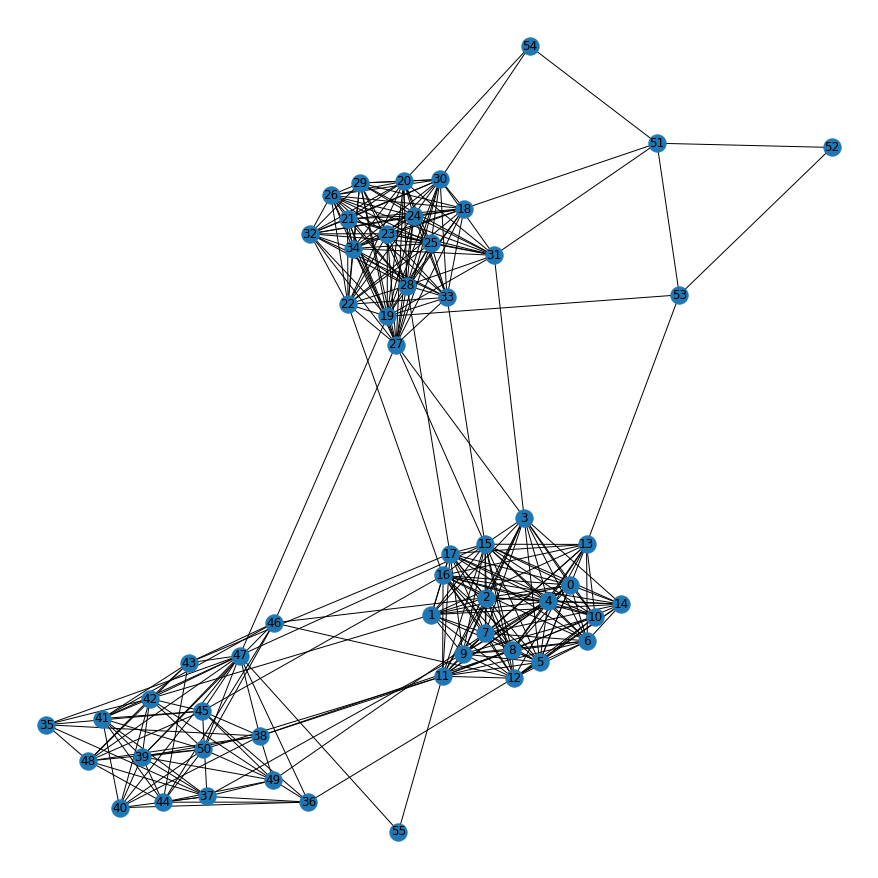

In [16]:
# ...your code here...
community_sizes_4 = [18, 17, 16, 5]
probabilities_4 = [
    [0.8, 0.03, 0.04, 0.02],
    [0.03, 0.9, 0.02, 0.03],
    [0.04, 0.02, 0.6, 0.01],
    [0.02, 0.03, 0.01, 0.7],
]
seed_4 = 100
SBM_4 = nx.stochastic_block_model(community_sizes_4, probabilities_4, seed=seed_4)
plt.figure(figsize=[12,12])
nx.draw(SBM_4, with_labels=True)
plt.show()

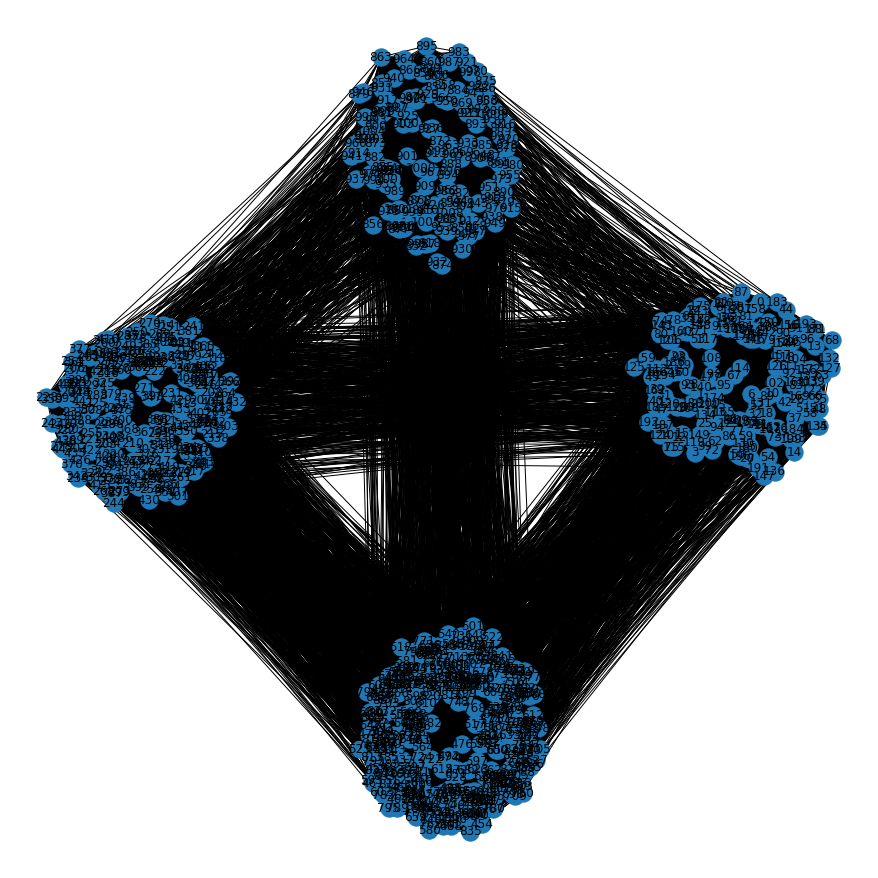

In [17]:
# ...your code here...
community_sizes_5 = [200, 250, 400, 160]
probabilities_5 = [
    [0.9, 0.01, 0.01, 0.01],
    [0.01, 0.9, 0.01, 0.01],
    [0.01, 0.01, 0.9, 0.01],
    [0.01, 0.01, 0.01, 0.9]
]
seed_5 = 88
SBM_5 = nx.stochastic_block_model(community_sizes_5, probabilities_5, seed=seed_5)
plt.figure(figsize=[12,12])
nx.draw(SBM_5, with_labels=True)
plt.show()

Explain your choice of parameters.
Write your explanation in the next cell.

<span style="color:purple">Answer here:</span> From SBM_1 and SBM_2, it can be seen that the number of communities has a relatively large impact on community detection, because the change of the number of communities will also affect the change of probability. 
From SBM_2 and SBM_3, it can be seen that the smaller the number of vertices within a communities, the simpler and clearer the community detection is. On the contrary, the more the number of vertices within a communities, the more complex the community detection.
From SBM_3 and SBM_4, it can be seen that the seed have no significant impact on community detection.
From SBM_2 and SBM_5, it can be seen that when the nodes within the community are more tightly connected and the connections between communities are more sparse, the resulting graph looks clearer.

### 5.2 Composite Model

Now generate at least five graphs using the composite model. Again, each graph should have order at least 1000.
You will want to give each graph a different name so that we can refer back to them throughout the project (*e.g., CM_1 through to CM_5*).
In each graph, be sure to change parameters such as:

- The number of nodes.
- The choice of background graph.
- The choice of community graph.
- The density of the background graph and the community graph.

For each graph, think about how changing the parameters will impact communities and community detection.
You should create **at least** one graph where the probability of an edge between different blocks is also high. Try to find out for what choice of parameters the community detection gets challenging.

<span style="color:red">IMPORTANT:</span>
Also provide unique names for the background graphs.
Depending on the graphs you create, this may be necessary to compute the ground truth matrix for the Rand Index.

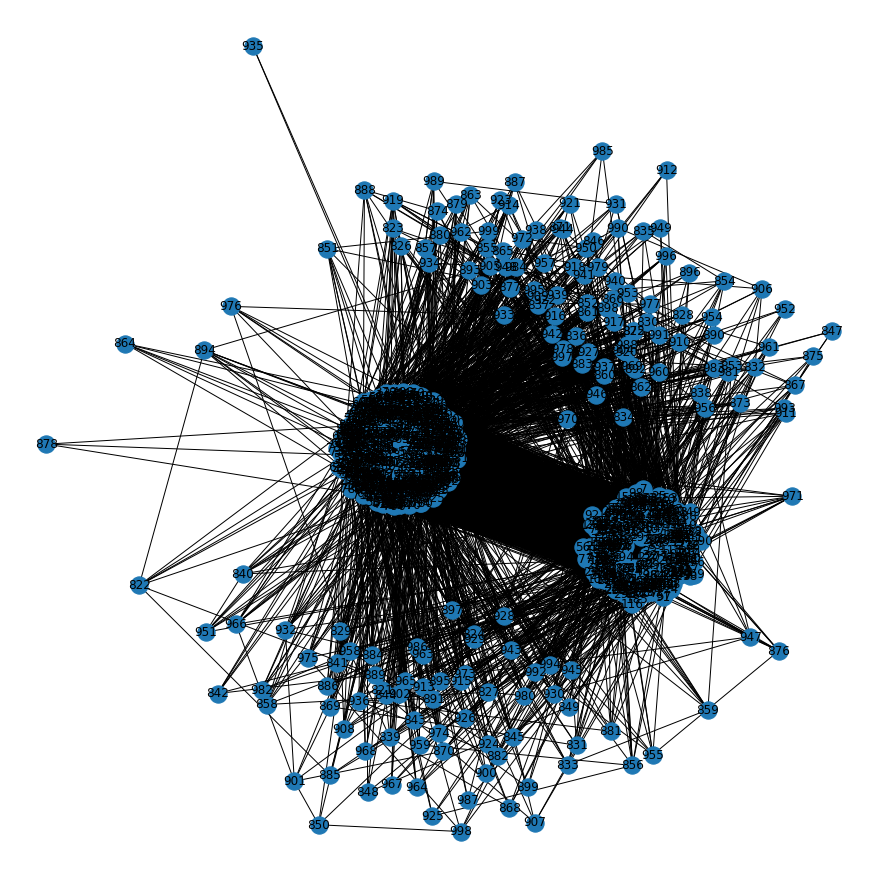

In [18]:
# ...your code here...
sid_1 = 1000
background_graph_1 = nx.erdos_renyi_graph(1000, 0.01, seed = sid_1)

# The first community is a dense random graph using nodes 0 to 300.
CM1_community_1 = nx.erdos_renyi_graph(301, 0.8, seed = sid_1)

# The second community is a dense random graph using nodes 301 to 820.
temporary_graph_1 = nx.erdos_renyi_graph(520, 0.7, seed = sid_1)
mapping_1 = dict(zip(temporary_graph_1, range(301,821)))
CM1_community_2 = nx.relabel_nodes(temporary_graph_1, mapping_1)

CM_1 = nx.compose(background_graph_1, CM1_community_1)
CM_1 = nx.compose(CM_1, CM1_community_2)
plt.figure(figsize=[12,12])
nx.draw(CM_1, with_labels=True)
plt.show()

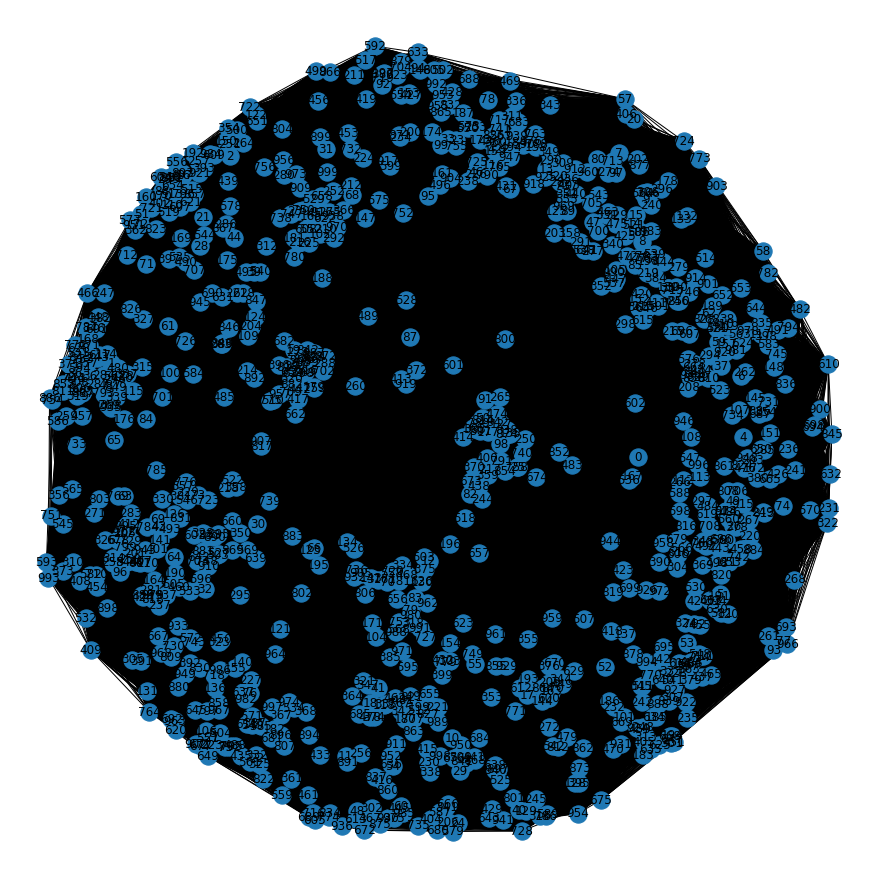

In [19]:
# ...your code here...
sid_2 = 100
background_graph_2 = nx.erdos_renyi_graph(1000, 0.9, seed = sid_2)

# The first community is a dense random graph using nodes 0 to 300.
CM2_community_1 = nx.erdos_renyi_graph(301, 0.8, seed = sid_2)

# The second community is a dense random graph using nodes 301 to 520.
temporary_graph_2 = nx.erdos_renyi_graph(220, 0.7, seed = sid_2)
mapping_2 = dict(zip(temporary_graph_2, range(301,521)))
CM2_community_2 = nx.relabel_nodes(temporary_graph_2, mapping_2)

CM_2 = nx.compose(background_graph_2, CM2_community_1)
CM_2 = nx.compose(CM_2, CM2_community_2)
plt.figure(figsize=[12,12])
nx.draw(CM_2, with_labels=True)
plt.show()

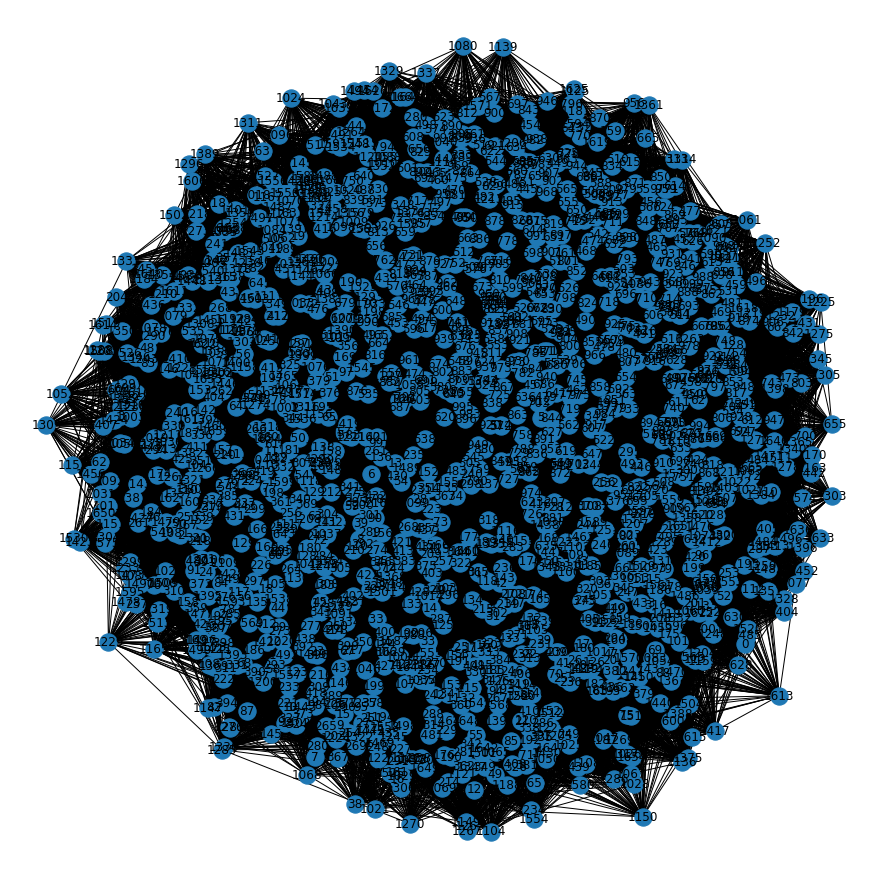

In [20]:
# ...your code here...
sid_3 = 10
background_graph_3 = nx.erdos_renyi_graph(1666, 0.05, seed = sid_3)

# The first community is a dense random graph using nodes 0 to 444.
CM3_community_1 = nx.erdos_renyi_graph(445, 0.04, seed = sid_3)

# The second community is a dense random graph using nodes 445 to 999.
temporary_graph_3 = nx.erdos_renyi_graph(555, 0.07, seed = sid_3)
mapping_3 = dict(zip(temporary_graph_3, range(445,1000)))
CM3_community_2 = nx.relabel_nodes(temporary_graph_3, mapping_3)

CM_3 = nx.compose(background_graph_3, CM3_community_1)
CM_3 = nx.compose(CM_3, CM3_community_2)
plt.figure(figsize=[12,12])
nx.draw(CM_3, with_labels=True)
plt.show()

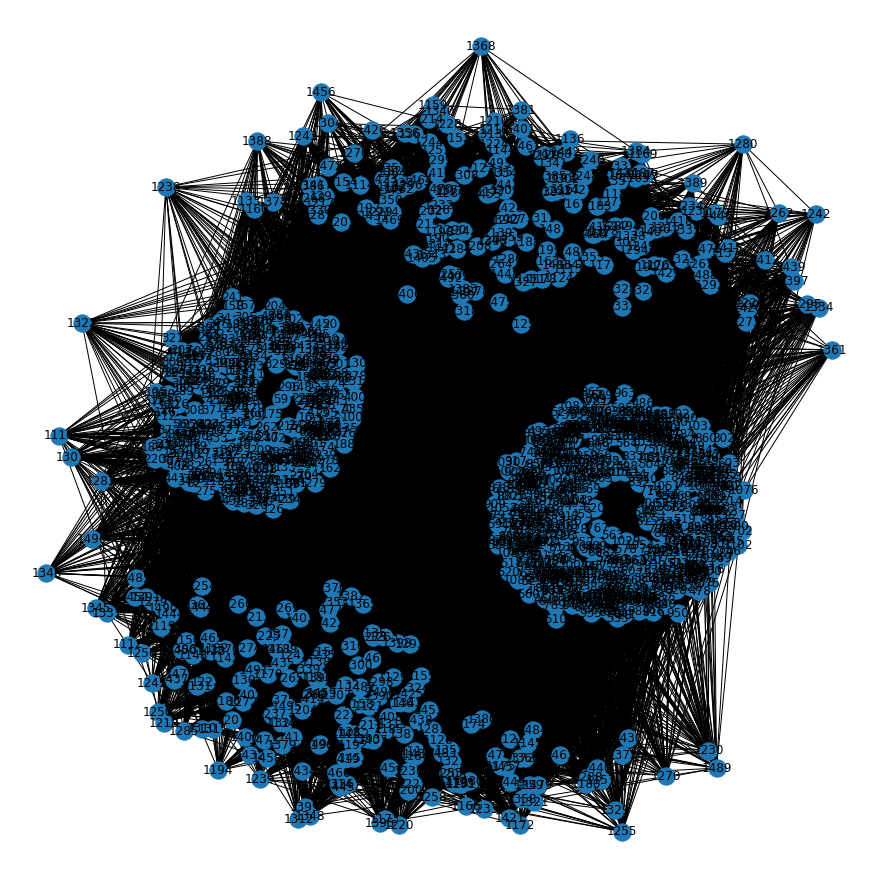

In [21]:
# ...your code here...
sid_4 = 100
background_graph_4 = nx.erdos_renyi_graph(1500, 0.04, seed = sid_4)

# The first community is a dense random graph using nodes 0 to 444.
CM4_community_1 = nx.erdos_renyi_graph(445, 0.9, seed = sid_4)

# The second community is a dense random graph using nodes 445 to 1111.
temporary_graph_4 = nx.erdos_renyi_graph(667, 0.7, seed = sid_4)
mapping_4 = dict(zip(temporary_graph_4, range(445,1112)))
CM4_community_2 = nx.relabel_nodes(temporary_graph_4, mapping_4)

CM_4 = nx.compose(background_graph_4, CM4_community_1)
CM_4 = nx.compose(CM_4, CM4_community_2)
plt.figure(figsize=[12,12])
nx.draw(CM_4, with_labels=True)
plt.show()

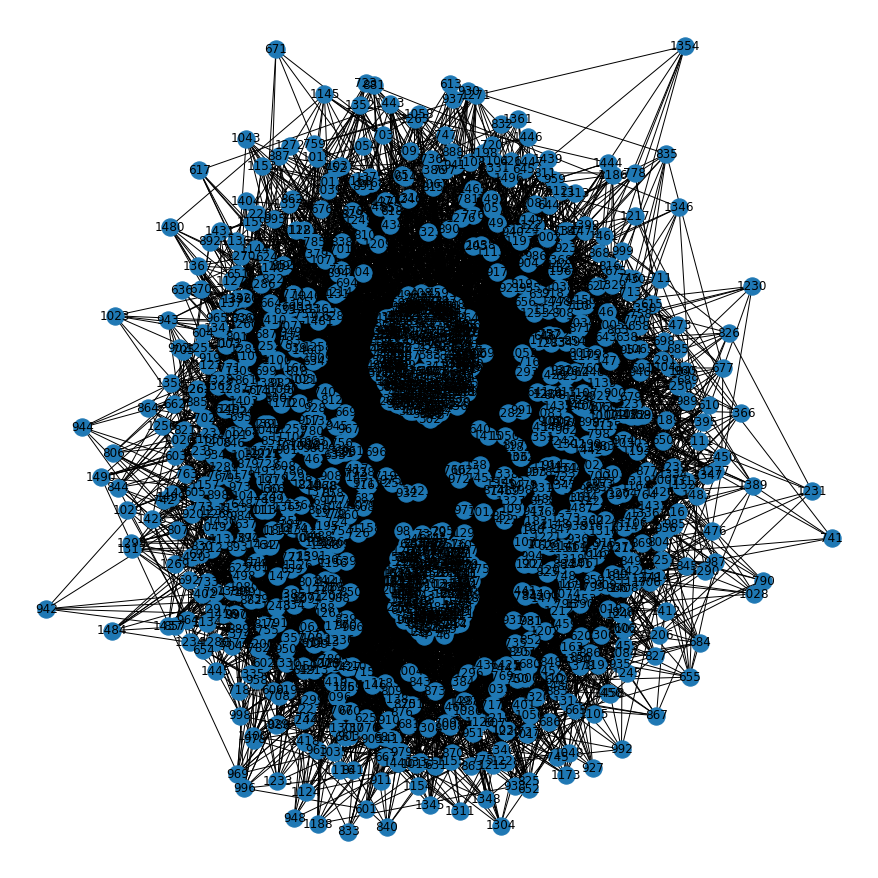

In [22]:
# ...your code here...
sid_5 = 100
background_graph_5 = nx.erdos_renyi_graph(1500, 0.01, seed = sid_5)

# The first community is a dense random graph using nodes 0 to 250.
CM5_community_1 = nx.erdos_renyi_graph(251, 0.9, seed = sid_5)

# The second community is a dense random graph using nodes 251 to 600.
temporary_graph_5 = nx.erdos_renyi_graph(350, 0.7, seed = sid_5)
mapping_5 = dict(zip(temporary_graph_5, range(251,601)))
CM5_community_2 = nx.relabel_nodes(temporary_graph_5, mapping_5)

CM_5 = nx.compose(background_graph_5, CM5_community_1)
CM_5 = nx.compose(CM_5, CM5_community_2)
plt.figure(figsize=[12,12])
nx.draw(CM_5, with_labels=True)
plt.show()

Explain your choice of parameters.
Write your explanation in the next cell.

<span style="color:purple">Answer here:</span> It can be seen from CM_1 and CM_2 that when the density of background graph is very high, it is impossible to distinguish which vertices belong to the community, and then the community detection gets challenging. Similarly, CM_3 shows, community detection also breaks down when the density within the community is low. Comparing CM_4 and CM_5, we can see that the image is clearer when the number of vertices in the background graph is smaller than the number of community vertices.

### 5.3 Label Propagation

Using the example in Section 3.1 as a template, apply label propogation to the graphs you generated throughout the previous two sections.
Try to understand the results, by printing the community sizes, and perhaps through visualization. Note how the background graph in classified for the composite graphs.


In [23]:
# Put code here that does a preliminary comparison of the community detection algorithms. 
# Compare sizes of S
SBM_communities_1 = []
for C in nx.community.label_propagation_communities(SBM_1):
    SBM_communities_1.append(SBM_1.subgraph(C))

print("Number of communities in SBM_1:", len(SBM_communities_1))
print("Community sizes in SBM_1:")
for community in SBM_communities_1:
    print(community.order())

Number of communities in SBM_1: 3
Community sizes in SBM_1:
660
200
250


In [24]:
SBM_communities_2 = []
for C in nx.community.label_propagation_communities(SBM_2):
    SBM_communities_2.append(SBM_2.subgraph(C))
    
print("Number of communities in SBM_2:", len(SBM_communities_2))
print("Community sizes in SBM_2:")
for community in SBM_communities_2:
    print(community.order())

Number of communities in SBM_2: 4
Community sizes in SBM_2:
250
160
400
200


In [25]:
SBM_communities_3 = []
for C in nx.community.label_propagation_communities(SBM_3):
    SBM_communities_3.append(SBM_3.subgraph(C))   

print("Number of communities in SBM_3:", len(SBM_communities_3))
print("Community sizes in SBM_3:")
for community in SBM_communities_3:
    print(community.order())

Number of communities in SBM_3: 4
Community sizes in SBM_3:
17
19
17
3


In [26]:
SBM_communities_4 = []
for C in nx.community.label_propagation_communities(SBM_4):
    SBM_communities_4.append(SBM_4.subgraph(C))

print("Number of communities in SBM_4:", len(SBM_communities_4))
print("Community sizes in SBM_4:")
for community in SBM_communities_4:
    print(community.order())

Number of communities in SBM_4: 3
Community sizes in SBM_4:
21
16
19


In [27]:
SBM_communities_5 = []
for C in nx.community.label_propagation_communities(SBM_5):
    SBM_communities_5.append(SBM_5.subgraph(C))

print("Number of communities in SBM_5:", len(SBM_communities_5))
print("Community sizes in SBM_5:")
for community in SBM_communities_5:
    print(community.order())

Number of communities in SBM_5: 4
Community sizes in SBM_5:
400
200
160
250


In [33]:
CM_communities_1 = []
for C in nx.community.label_propagation_communities(CM_1):
    CM_communities_1.append(CM_1.subgraph(C))

print("Number of communities in CM_1:", len(CM_communities_1))
print("Community sizes in CM_1:")
for community in CM_communities_1:
    print(community.order())

Number of communities in CM_1: 2
Community sizes in CM_1:
666
334


In [34]:
CM_communities_2 = []
for C in nx.community.label_propagation_communities(CM_2):
    CM_communities_2.append(CM_2.subgraph(C))

print("Number of communities in CM_2:", len(CM_communities_2))
print("Community sizes in CM_2:")
for community in CM_communities_2:
    print(community.order())

Number of communities in CM_2: 1
Community sizes in CM_2:
1000


In [35]:
CM_communities_3 = []
for C in nx.community.label_propagation_communities(CM_3):
    CM_communities_3.append(CM_3.subgraph(C))

print("Number of communities in CM_3:", len(CM_communities_3))
print("Community sizes in CM_3:")
for community in CM_communities_3:
    print(community.order())

Number of communities in CM_3: 1
Community sizes in CM_3:
1666


In [36]:
CM_communities_4 = []
for C in nx.community.label_propagation_communities(CM_4):
    CM_communities_4.append(CM_4.subgraph(C))

print("Number of communities in CM_4:", len(CM_communities_4))
print("Community sizes in CM_4:")
for community in CM_communities_4:
    print(community.order())

Number of communities in CM_4: 1
Community sizes in CM_4:
1500


In [37]:
CM_communities_5 = []
for C in nx.community.label_propagation_communities(CM_5):
    CM_communities_5.append(CM_5.subgraph(C))

print("Number of communities in CM_5:", len(CM_communities_5))
print("Community sizes in CM_5:")
for community in CM_communities_5:
    print(community.order())

Number of communities in CM_5: 1
Community sizes in CM_5:
1500


<span style="color:purple">Put any explanatory text here:</span> It can be seen from the results that label propagation is suitable for stochastic block model, but not for composite model. Because label propagation in composite model assigns the vertices of the background graph to the community. In the stochastic block model, some different results will be generated due to the choice of parameters. For example, in SBM_3 and SBM_4, some communities are small in size, so the number and size of communities will have some deviation. In SBM_2 and SBM_5, the result is the same as what we set up.

### 5.4 Modularity Optimization

Using the example in Section 3.2 as a template, apply label modularity optimization to the graphs you generated throughout the first two sections. As in the previous sections, try to understand the results.

In [38]:
# put your modularity optimization code here
SBM_communities_1 = []
for C in nx.community.greedy_modularity_communities(SBM_1):
    SBM_communities_1.append(SBM_1.subgraph(C))

print("Number of communities in SBM_1:", len(SBM_communities_1))
print("Community sizes in SBM_1:")
for community in SBM_communities_1:
    print(community.order())

Number of communities in SBM_1: 4
Community sizes in SBM_1:
400
300
250
160


In [39]:
SBM_communities_2 = []
for C in nx.community.greedy_modularity_communities(SBM_2):
    SBM_communities_2.append(SBM_2.subgraph(C))
    
print("Number of communities in SBM_2:", len(SBM_communities_2))
print("Community sizes in SBM_2:")
for community in SBM_communities_2:
    print(community.order())

Number of communities in SBM_2: 4
Community sizes in SBM_2:
400
250
200
160


In [40]:
SBM_communities_3 = []
for C in nx.community.greedy_modularity_communities(SBM_3):
    SBM_communities_3.append(SBM_3.subgraph(C))   

print("Number of communities in SBM_3:", len(SBM_communities_3))
print("Community sizes in SBM_3:")
for community in SBM_communities_3:
    print(community.order())

Number of communities in SBM_3: 4
Community sizes in SBM_3:
18
17
16
5


In [41]:
SBM_communities_4 = []
for C in nx.community.greedy_modularity_communities(SBM_4):
    SBM_communities_4.append(SBM_4.subgraph(C))

print("Number of communities in SBM_4:", len(SBM_communities_4))
print("Community sizes in SBM_4:")
for community in SBM_communities_4:
    print(community.order())

Number of communities in SBM_4: 4
Community sizes in SBM_4:
18
17
17
4


In [42]:
SBM_communities_5 = []
for C in nx.community.greedy_modularity_communities(SBM_5):
    SBM_communities_5.append(SBM_5.subgraph(C))

print("Number of communities in SBM_5:", len(SBM_communities_5))
print("Community sizes in SBM_5:")
for community in SBM_communities_5:
    print(community.order())

Number of communities in SBM_5: 4
Community sizes in SBM_5:
400
250
200
160


In [43]:
CM_communities_1 = []
for C in nx.community.greedy_modularity_communities(CM_1):
    CM_communities_1.append(CM_1.subgraph(C))
    
print("Number of communities in CM_1:", len(CM_communities_1))
print("Community sizes in CM_1:")
for community in CM_communities_1:
    print(community.order())

Number of communities in CM_1: 6
Community sizes in CM_1:
530
416
28
22
2
2


In [44]:
CM_communities_2 = []
for C in nx.community.greedy_modularity_communities(CM_2):
    CM_communities_2.append(CM_2.subgraph(C))

print("Number of communities in CM_2:", len(CM_communities_2))
print("Community sizes in CM_2:")
for community in CM_communities_2:
    print(community.order())

Number of communities in CM_2: 2
Community sizes in CM_2:
596
404


In [45]:
CM_communities_3 = []
for C in nx.community.greedy_modularity_communities(CM_3):
    CM_communities_3.append(CM_3.subgraph(C))

print("Number of communities in CM_3:", len(CM_communities_3))
print("Community sizes in CM_3:")
for community in CM_communities_3:
    print(community.order())

Number of communities in CM_3: 3
Community sizes in CM_3:
883
565
218


In [46]:
CM_communities_4 = []
for C in nx.community.greedy_modularity_communities(CM_4):
    # The community is a list of nodes.
    CM_communities_4.append(CM_4.subgraph(C))
    
print("Number of communities in CM_4:", len(CM_communities_4))
print("Community sizes in CM_4:")
for community in CM_communities_4:
    print(community.order())

Number of communities in CM_4: 2
Community sizes in CM_4:
830
670


In [47]:
CM_communities_5 = []
for C in nx.community.greedy_modularity_communities(CM_5):
    CM_communities_5.append(CM_5.subgraph(C))

print("Number of communities in CM_5:", len(CM_communities_5))
print("Community sizes in CM_5:")
for community in CM_communities_5:
    print(community.order())

Number of communities in CM_5: 3
Community sizes in CM_5:
883
353
264


<span style="color:purple">Put any explanatory text here:</span>Modularity optimization is applicable to both stochastic block model and composite model, and the other results are similar to what we expect except the unreasonable parameter selection of some models.

### 5.5 Girvan-Newman algorithm

Using the example in Section 3.3 as a template, apply label modularity optimization to the graphs you generated throughout the previous two sections. See what happens if you choose a partition with more or fewer communities than the ground truth. As in the first sections, try to understand the results. 

<span style="color:blue">NOTE:</span>
Girvan-Newman as implemented in NetworkX is very slow. Use it only for the smaller graphs you generated. 

In [48]:
# put your Girvan-Newman code here
SBM_comp_3 = nx.community.girvan_newman(SBM_3)

k = 4
t = 3 # Must be that 2 <= t <= k+1, this is the number of communities we extract.
for partition in itertools.islice(SBM_comp_3, k):
    # Picks out the partition that has t parts.
    if len(partition) == t:
        chosen_SBM_partition_3 = partition
    # chosen_partition is the partition that has t parts

# Turn the communities into subgraphs.
SBM_GN_communities_3 = []
for C in chosen_SBM_partition_3:
    SBM_GN_communities_3.append(SBM_3.subgraph(C))
        
print("Number of communities in SBM_3:", len(SBM_GN_communities_3)) # This should be equal to t.
print("Community sizes in SBM_3:")
for community in SBM_GN_communities_3:
    print(community.order())

Number of communities in SBM_3: 3
Community sizes in SBM_3:
23
17
16


In [49]:
SBM_comp_4 = nx.community.girvan_newman(SBM_4)

k = 4
t = 5 # Must be that 2 <= t <= k+1, this is the number of communities we extract.
for partition in itertools.islice(SBM_comp_4, k):
    # Picks out the partition that has t parts.
    if len(partition) == t:
        chosen_SBM_partition_4 = partition
    # chosen_partition is the partition that has t parts

# Turn the communities into subgraphs.
SBM_GN_communities_4 = []
for C in chosen_SBM_partition_4:
    SBM_GN_communities_4.append(SBM_4.subgraph(C))
        
print("Number of communities in SBM_4:", len(SBM_GN_communities_4)) # This should be equal to t.
print("Community sizes in SBM_4:")
for community in SBM_GN_communities_4:
    print(community.order())

Number of communities in SBM_4: 5
Community sizes in SBM_4:
18
18
16
3
1


Briefly explain how you selected the partitions.
Write your explanation in the next cell, as well as any other observations.

<span style="color:purple">Put any explanatory text here:</span> When a partition with fewer communities than the ground truth, the vertices in the deleted communities will be added to the existing communities. When a partition with more communities than the ground truth, the existing communities will assign some vertices to newly joined communities.

### 5.6 Rand Index

Using the code from Section 4.1 as a template, compute the Rand Index of each partition you found, and discuss the results.

In [50]:
# put your calculations here
t = 0
ground_truth_3 = []
for n in community_sizes_3:
    ground_truth_3.append(list(range(t, t+n)))
    t = t+n

n = SBM_3.order()

ground_truth_matrix_3 = np.zeros([n, n], dtype=int)
for community in ground_truth_3:
    for i in community:
        for j in community:
            ground_truth_matrix_3[i][j] = 1

empirical_matrix_3 = np.zeros([n, n], dtype=int)
for community in SBM_communities_3:
    for i in community:
        for j in community:
            empirical_matrix_3[i][j] = 1

a = 0
b = 0
for i in range(0, n):
    for j in range(i + 1, n):
        if ground_truth_matrix_3[i, j] == 1 and empirical_matrix_3[i][j] == 1:
            a += 1
        if ground_truth_matrix_3[i, j] == 0 and empirical_matrix_3[i][j] == 0:
            b += 1
rand_index_3 = (a + b) / (n * (n - 1) / 2.0)
print("The Rand Index of SBM_3:", rand_index_3)

The Rand Index of SBM_3: 1.0


In [51]:
t = 0
ground_truth_4 = []
for n in community_sizes_4:
    ground_truth_4.append(list(range(t, t+n)))
    t = t+n

n = SBM_4.order()

ground_truth_matrix_4 = np.zeros([n, n], dtype=int)
for community in ground_truth_4:
    for i in community:
        for j in community:
            ground_truth_matrix_4[i][j] = 1

empirical_matrix_4 = np.zeros([n, n], dtype=int)
for community in SBM_communities_4:
    for i in community:
        for j in community:
            empirical_matrix_4[i][j] = 1

a = 0
b = 0
for i in range(0, n):
    for j in range(i + 1, n):
        if ground_truth_matrix_4[i, j] == 1 and empirical_matrix_4[i][j] == 1:
            a += 1
        if ground_truth_matrix_4[i, j] == 0 and empirical_matrix_4[i][j] == 0:
            b += 1
rand_index_4 = (a + b) / (n * (n - 1) / 2.0)
print("The Rand Index of SBM_4:", rand_index_4)

The Rand Index of SBM_4: 0.987012987012987


<span style="color:purple">Discuss your results here:</span> The rand index in SBM_3 is 1.0, which means that the communities found by the community detection algorithm are consistent with the communities created by us. The rand index in SBM_4, though less than 1.0, is also very close, indicating that there is a slight difference between the communities found by the community detection algorithm and the communities created by us.

### 5.7 Modularity

Using the code in Section 4.2 as an example, compute the modularity of each partition you found, and discuss the results.

In [52]:
## put your code to compute modularity here
nx.community.modularity(SBM_3,SBM_communities_3)

0.5743054033652324

In [53]:
nx.community.modularity(SBM_4,SBM_communities_4)

0.5827631344082823

<span style="color:purple">Discuss your results here:</span> The modularity of SBM_3 and SBM_4 is very high, which means that they are clearly divided into communities. Nodes within the module are densely connected, and nodes among different modules are sparsely connected.

### 5.8 Summary and Conclusions

This concludes your exploratory analysis of community detection.
Now you will take some time to reflect on the results.
Specifically, answer the following 4 discussion questions.
Note that your answers should reflect the graphs you selected, and the choices you made throughout the Notebook.
This means that your answers might differ from those of your classmates.
You will be graded on your ability to critically analyze the results.
You can use the following four questions as a guide, but also add any additional observations.

1. Which parameters from Sect. 2 had the greatest impact on community detection?
   Why do you think this is?
   If you did not observe any impact from the parameters, what parameters do you suspect might impact community detection.
2. Did you find that certain community detection algorithms performed better for certain graphs?
3. Did the modularity and Rand Index align with your observations from visualizing the graphs?
4. Did the modularity and Rand Index always agree?
   If not, why do you think this was the case?
   If the modularity and Rand Index always agreed, can you think of a situation where the modularity and Rand Index might disagree?

<span style="color:purple">Answer here:</span> 
In the stochastic block model, the number of communities and the probability in the probability matrix have a great influence on community detection. Because as the number of communities changes, it affects the number of vertices in the community along with the probability matrix. All other things being equal, different probability matrices generate completely different graphs.

In the composite model, the density of the background graph and community graph has a great influence on community detection. When their densities are both large and small, there is no discernible community division.

It can be seen from section 5.3, the label propagation is suitable for the stochastic block model, but not for the composite model. Because label propagation in the composite model assigns the vertices of the background graph to the community. Modularity optimization is applicable to both the stochastic block model and composite model.

I've observed that modularity and the rand index always agree. Since modularity does not require knowledge of the real communities, I suspect that modularity will merge some of the smaller communities when the number of nodes is low, which does not happen with the rand index because it will be compared to the real community. Then modularity and the rand index will produce a certain deviation.